<a href="https://colab.research.google.com/github/masa512/SA/blob/main/SA_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ../content
!git clone https://masa512:@github.com/masa512/SA.git

!git config --global user.email "ms4@illinois.edu"
!git config --global user.name "masa512"

%cd SA

/content
Cloning into 'SA'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 53 (delta 23), reused 23 (delta 9), pack-reused 0
Unpacking objects: 100% (53/53), 1.33 MiB | 4.23 MiB/s, done.
/content/SA


In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import circ_sample
import data_process
import model
import loss
import torch.optim as optim

from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test Circular Sample Function

# Plotting 2D Fourier Spectrum before sampling and after sample at center

# Stitching operation

In [23]:
!git commit -a -m "Final commit before "

NotImplementedError: ignored

In [54]:
!git push origin main


Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 317 bytes | 317.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/masa512/SA.git
   1892aa0..d5a9be3  main -> main


In [4]:

!unzip "data.zip" -d "."


Archive:  data.zip
   creating: ./data/
  inflating: ./data/.DS_Store        
  inflating: ./__MACOSX/data/._.DS_Store  
   creating: ./data/test/
   creating: ./data/train/
  inflating: ./data/test/51_256.jpg  
  inflating: ./__MACOSX/data/test/._51_256.jpg  
  inflating: ./data/test/41_256.jpg  
  inflating: ./__MACOSX/data/test/._41_256.jpg  
  inflating: ./data/test/33_256.jpg  
  inflating: ./__MACOSX/data/test/._33_256.jpg  
  inflating: ./data/test/23_256.jpg  
  inflating: ./__MACOSX/data/test/._23_256.jpg  
  inflating: ./data/test/15_256.jpg  
  inflating: ./__MACOSX/data/test/._15_256.jpg  
  inflating: ./data/test/6_256.jpg   
  inflating: ./__MACOSX/data/test/._6_256.jpg  
  inflating: ./data/test/77_256.jpg  
  inflating: ./__MACOSX/data/test/._77_256.jpg  
  inflating: ./data/test/67_256.jpg  
  inflating: ./__MACOSX/data/test/._67_256.jpg  
  inflating: ./data/test/93_256.jpg  
  inflating: ./__MACOSX/data/test/._93_256.jpg  
  inflating: ./data/test/83_256.jpg  
  infl

In [5]:
trainset = data_process.dog_train_dataset(rad=30,L=3)
testset = data_process.dog_test_dataset(rad=30,L=3)

In [31]:
(I,F,M) = testset[0]

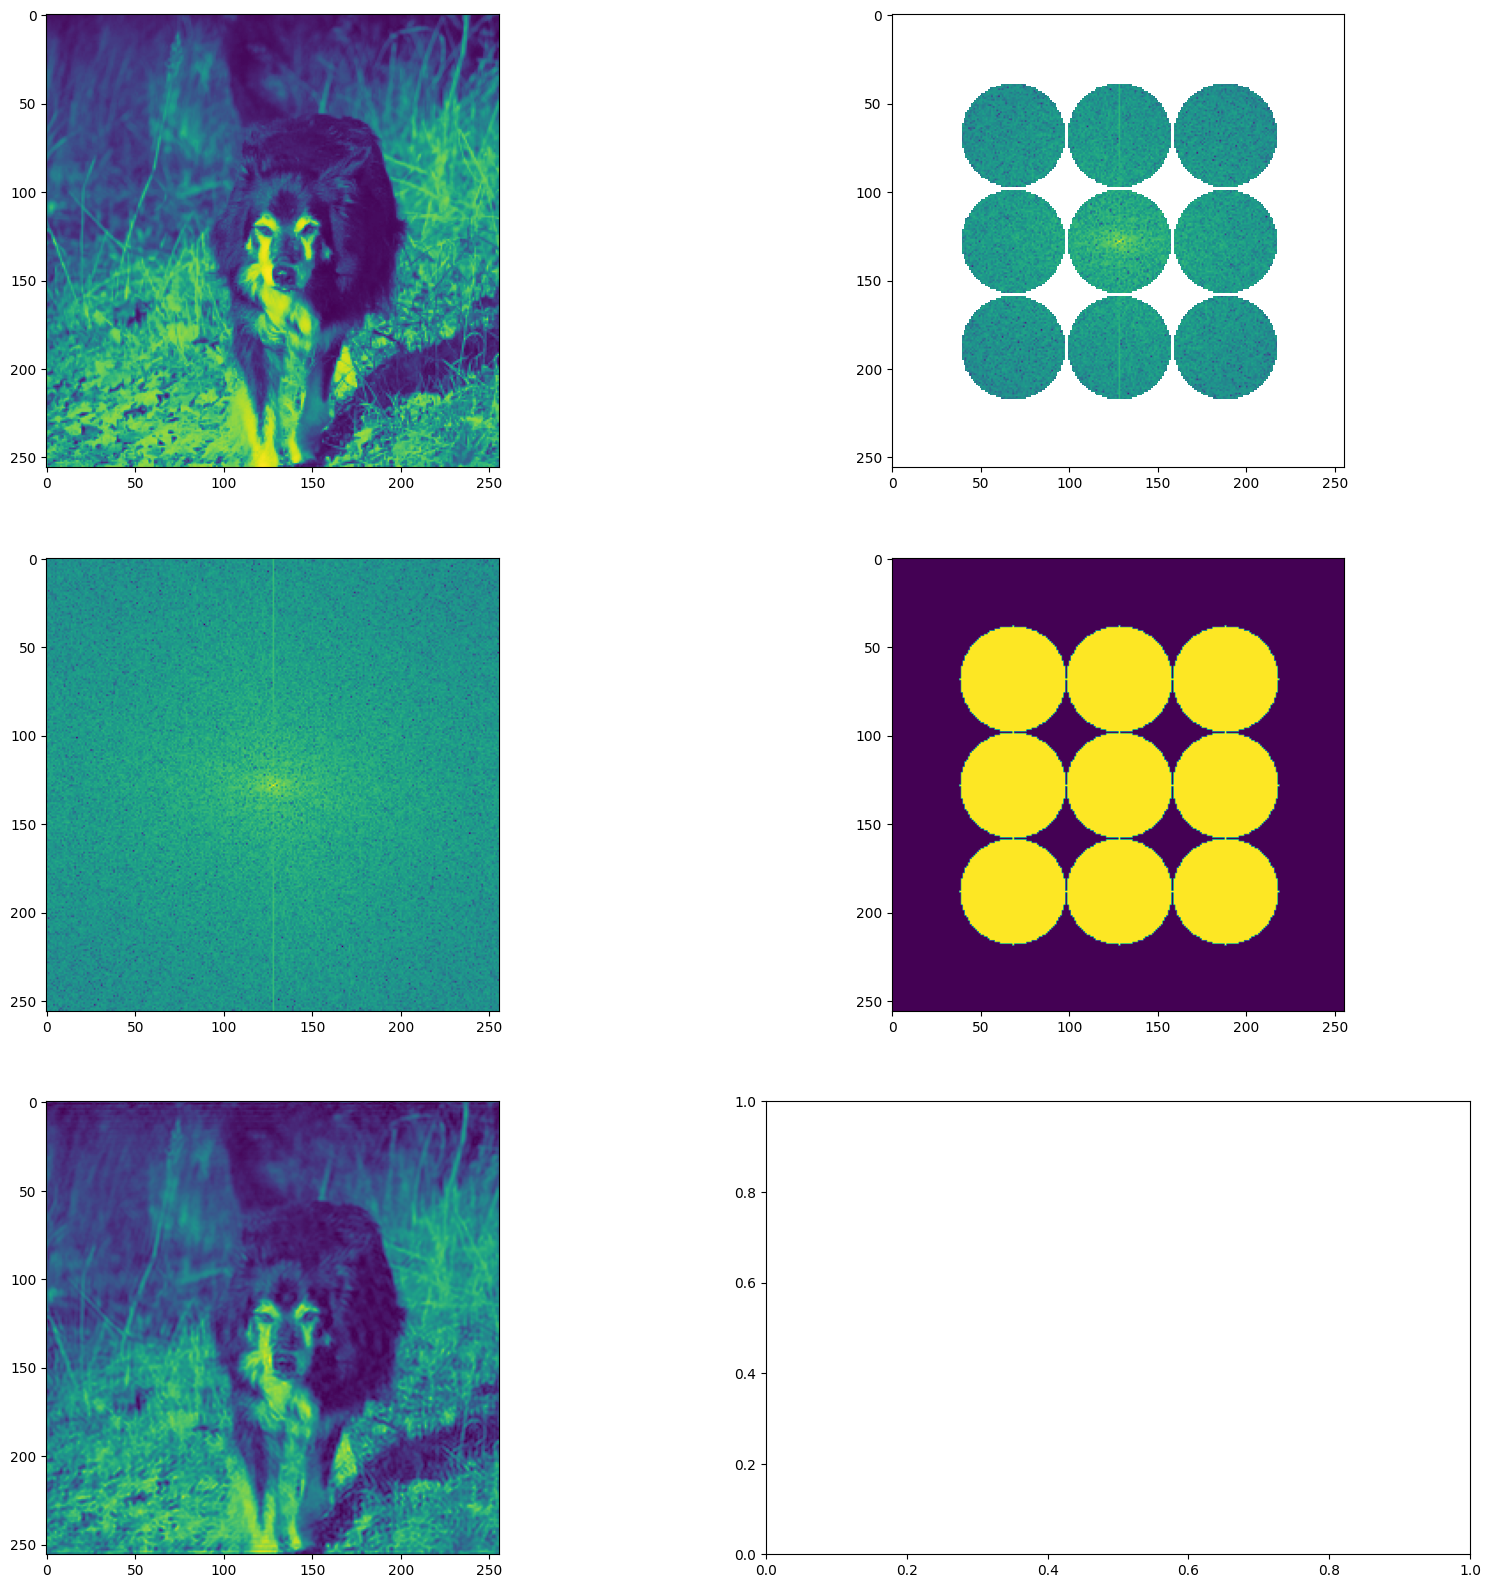

In [33]:
from scipy.fft import ifftn,fftn,fftshift,ifftshift

f,axes = plt.subplots(3,2,figsize=(20,20))
axes = np.ravel(axes)
import torch
m = M[0,:,:]
axes[0].imshow(I)
axes[1].imshow(torch.log(abs(F[0,:,:]*m)))
axes[2].imshow(torch.log(abs(F[0,:,:])))
axes[3].imshow(m)
axes[4].imshow(abs(ifftn(ifftshift(m*(F[0,:,:]+1j*F[1,:,:])))))

In [6]:
from torch.utils.data import DataLoader

batchsize = 16
trainloader = DataLoader(trainset,16,shuffle=True)
testloader = DataLoader(testset,1,shuffle=False)

# Loss

1. Reconstruction loss on image domain
2. Smoothness constraint on the Fourier spectrum

# Training Sequence

In [19]:
def train(net,num_epochs,train_loader,test_loader,optimizer,lr_scheduler,lmbda):

  # Training_set
  # Epoch loss to return
  t_train_loss = []
  t_val_loss = []

  #Loss fnx
  loss1 = loss.recon_loss().to('cuda')
  loss2 = loss.s_loss(lmb=lmbda).to('cuda')

  # Training loop
  for t in range(num_epochs):
    print(f"------------epoch{t+1}--------------")
    net.train() # train mode
    b_train_loss = [] # batch_loss for training
    b_val_loss = [] # batch_loss for validation

    net.train()
    for I,F,M in tqdm(train_loader):
      # zero_gradient
      optimizer.zero_grad()

      # Parameters to cuda
      I = I.to('cuda')
      F = F.to('cuda')
      M = M.to('cuda')

      # Prediction over input images
      F_out = net(F,M)

      # Evaluate compound loss function
      L = loss1(F,F_out,M,I) + loss2(F_out,M)

      # Backprop
      L.backward()
      optimizer.step()

      # Append to b_train_loss (batch)
      b_train_loss.append(L.item())

    net.eval()
    with torch.no_grad():
      for I,F,M in tqdm(test_loader):
        # Parameters to cuda
        I = I.to('cuda')
        F = F.to('cuda')
        M = M.to('cuda')

        # Prediction over input images
        F_out = net(F,M)

        # Evaluate compound loss function
        L = loss1(F,F_out,M,I) + loss2(F_out,M)

        # append to b_val_loss (batch)
        b_val_loss.append(L.item())

    # Save the losses to t_val/t_train loss
    t_train_loss.append(np.mean(b_train_loss))
    t_val_loss.append(np.mean(b_val_loss))

    # Print out the validation loss
    print(f'===> Epoch {t+1}: Train Loss -> {t_train_loss[-1]}')
    print(f'===> Epoch {t+1}: Validation Loss -> {t_val_loss[-1]}')

  

In [22]:
net = model.PUnet(2,16,2).to('cuda')
lr = 5e-5
optimizer = optim.Adam(net.parameters(),lr=lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=2)
num_epochs = 30
lmbda = 0.01

train(net,num_epochs,trainloader,testloader,optimizer,lr_scheduler,lmbda)

------------epoch1--------------


100%|██████████| 100/100 [00:02<00:00, 40.32it/s]


===> Epoch 1: Train Loss -> 0.13574507902376354
===> Epoch 1: Validation Loss -> 0.012427394594997167
------------epoch2--------------


100%|██████████| 100/100 [00:02<00:00, 40.22it/s]


===> Epoch 2: Train Loss -> 0.1336859550792724
===> Epoch 2: Validation Loss -> 0.012420195499435066
------------epoch3--------------


100%|██████████| 100/100 [00:02<00:00, 40.72it/s]


===> Epoch 3: Train Loss -> 0.13263094308786094
===> Epoch 3: Validation Loss -> 0.012418488282710314
------------epoch4--------------


100%|██████████| 100/100 [00:02<00:00, 40.64it/s]


===> Epoch 4: Train Loss -> 0.13585223187692463
===> Epoch 4: Validation Loss -> 0.0124179723020643
------------epoch5--------------


100%|██████████| 100/100 [00:02<00:00, 40.83it/s]


===> Epoch 5: Train Loss -> 0.13372586155310273
===> Epoch 5: Validation Loss -> 0.01241777891293168
------------epoch6--------------


100%|██████████| 100/100 [00:02<00:00, 40.56it/s]


===> Epoch 6: Train Loss -> 0.1361319669522345
===> Epoch 6: Validation Loss -> 0.01241754025220871
------------epoch7--------------


100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


===> Epoch 7: Train Loss -> 0.13578080828301609
===> Epoch 7: Validation Loss -> 0.012417429946362973
------------epoch8--------------


100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


===> Epoch 8: Train Loss -> 0.13562464877031744
===> Epoch 8: Validation Loss -> 0.012417321065440775
------------epoch9--------------


100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


===> Epoch 9: Train Loss -> 0.13363961852155626
===> Epoch 9: Validation Loss -> 0.01241728094406426
------------epoch10--------------


100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


===> Epoch 10: Train Loss -> 0.13848048588261008
===> Epoch 10: Validation Loss -> 0.0124172037653625
------------epoch11--------------


100%|██████████| 100/100 [00:02<00:00, 40.20it/s]


===> Epoch 11: Train Loss -> 0.1360020984429866
===> Epoch 11: Validation Loss -> 0.012417158233001829
------------epoch12--------------


 94%|█████████▍| 30/32 [00:10<00:00,  2.99it/s]


KeyboardInterrupt: ignored